In [2]:
import pandas as pd
import ast
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\theal\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [14]:
import pandas as pd
import ast
import nltk
import spacy

# You gotta run this
#   python -m spacy download en_core_web_sm


def flatten_conversation_history(df):
    """
    Flatten conversation_history in the DataFrame 'df'.
    
    Returns a new turn-level DataFrame with columns:
      [conversation_id, user_id, turn, role, content]
    """
    all_turns = []
    for idx, row in df.iterrows():
        try:
            history_list = ast.literal_eval(row['conversation_history'])
        except Exception as e:
            print(f"Error parsing row {idx} with conversation_id={row.get('conversation_id')}:\n{e}")
            history_list = []
        
        # Build turn-level rows
        for turn_dict in history_list:
            all_turns.append({
                'conversation_id': row['conversation_id'],
                'user_id': row['user_id'],
                'turn': turn_dict.get('turn', None),
                'role': turn_dict.get('role', ''),
                'content': turn_dict.get('content', ''),
                'model': turn_dict.get('model_name', '')
            })
            
    return pd.DataFrame(all_turns)

def get_word_count(text):
    """
    Returns the number of tokens in the string 'text'.
    """
    tokens = nltk.word_tokenize(text)
    return len(tokens)

def get_ttr(text):
    """
    Returns the type-token ratio of the string 'text'.
    """
    tokens = nltk.word_tokenize(text)
    if len(tokens) == 0:
        return 0
    return len(set(tokens)) / len(tokens)

def get_syntactic_metrics(text):
    """
    Returns a dict with {'avg_sentence_length', 'max_dep_tree_depth'}.
    """
    doc = nlp(text)
    num_sentences = len(list(doc.sents))
    total_words = len([t for t in doc if not t.is_punct])
    avg_sentence_length = (total_words / num_sentences) if num_sentences > 0 else 0
    
    max_depth = 0
    for token in doc:
        depth = 0
        current = token
        while current.head != current:
            current = current.head
            depth += 1
        max_depth = max(max_depth, depth)

    return {
        'avg_sentence_length': avg_sentence_length,
        'max_dep_tree_depth': max_depth
    }


In [20]:
df = pd.read_csv("important_data_v2.csv")


print("Initial df shape:", df.shape)
print("Columns in df:", df.columns.tolist())

df_turns = flatten_conversation_history(df)
print("\nFlattened df_turns (first 5 rows):")
print(df_turns.head())

df_turns['word_count'] = df_turns['content'].apply(get_word_count)
df_turns['TTR'] = df_turns['content'].apply(get_ttr)

syntactic_info = df_turns['content'].apply(get_syntactic_metrics)
df_turns['avg_sentence_length'] = syntactic_info.apply(lambda x: x['avg_sentence_length'])
df_turns['parse_tree_depth'] = syntactic_info.apply(lambda x: x['max_dep_tree_depth'])


df_turns_users = df_turns[df_turns['role'] == 'user'].copy()


# d) Aggregate to user level
user_level = (
    df_turns_users
    .groupby("user_id")
    .agg({
        "word_count": "mean",
        "TTR": "mean",
        "avg_sentence_length": "mean",
        "parse_tree_depth": "mean"
    })
    .reset_index()
    .rename(columns={
        "word_count": "mean_word_count",
        "TTR": "mean_TTR",
        "avg_sentence_length": "mean_avg_sentence_length",
        "parse_tree_depth": "mean_parse_tree_depth"
    })
)


Initial df shape: (154, 16)
Columns in df: ['conversation_id', 'user_id', 'opening_prompt', 'conversation_history', 'lm_familiarity', 'lm_frequency_use', 'age', 'gender', 'employment_status', 'education', 'marital_status', 'english_proficiency', 'study_locale', 'religion', 'ethnicity', 'location']

Flattened df_turns (first 5 rows):
  conversation_id user_id  turn   role  \
0             c23   user9     0   user   
1             c23   user9     0  model   
2             c23   user9     0  model   
3             c23   user9     0  model   
4             c23   user9     1   user   

                                             content  \
0   I would like to write a poem about my white cat.   
1  Here is a 47-word poem about a white cat:\n\nF...   
2  Here is a 47-word poem about a white cat:\n\nF...   
3  Sure, I can help you with that! What kind of p...   
4                  I would like it to be a limerick.   

                            model  
0                                  
1  

In [21]:
df.iloc[0]['conversation_history']

'[{\'turn\': 0, \'role\': \'user\', \'content\': \'I would like to write a poem about my white cat.\'}, {\'turn\': 0, \'role\': \'model\', \'content\': "Here is a 47-word poem about a white cat:\\n\\nFur as white as fallen snow, \\nWith eyes of clearest blue,\\nOn quiet paws you softly go,\\nNot making much ado.\\nYou curl up small to take a nap,\\nYour tail wrapped round your side,\\nAnd when you wake you stretch and yap,\\nMy sweet cat, winter\'s bride.", \'model_provider\': \'anthropic\', \'model_name\': \'claude-2.1\', \'score\': 69, \'if_chosen\': False, \'within_turn_id\': 0}, {\'turn\': 0, \'role\': \'model\', \'content\': \'Here is a 47-word poem about a white cat:\\n\\nFur as white as fallen snow, \\nWith eyes of clearest blue,\\nPaws that softly come and go,\\nFilled with grace in all you do.\\nCurled up purring by my side,\\nA comforting, gentle friend - \\nMy sweet white cat, in whom I confide,\\nLoyal companion without end.\', \'model_provider\': \'anthropic\', \'model_nam

In [22]:
df_turns_users

,conversation_id,user_id,turn,role,content,model,word_count,TTR,avg_sentence_length,parse_tree_depth
0,c23,user9,0,user,I would like to write a poem about my white cat.,,12,1.000000,11.0,5
4,c23,user9,1,user,I would like it to be a limerick.,,9,1.000000,8.0,3
7,c23,user9,2,user,Could you try a free form poem. My cat is a bo...,,19,0.894737,8.5,3
10,c23,user9,3,user,That was good. I am happy with the first poem.,,12,0.916667,5.0,4
13,c23,user9,4,user,A title would be good.,,6,1.000000,5.0,2
...,...,...,...,...,...,...,...,...,...,...
3029,c7990,user1497,1,user,Which do you reccomend to use iPhone or Android?,,10,1.000000,9.0,3
3032,c7990,user1497,2,user,"Understood, thank you. Do you know Steve Jobs?",,11,0.909091,4.0,2
3035,c7990,user1497,3,user,Is he stil alive?,,5,1.000000,4.0,1
3038,c7990,user1497,4,user,I'm sorry to hear that.,,7,1.000000,6.0,3


In [23]:
user_level

,user_id,mean_word_count,mean_TTR,mean_avg_sentence_length,mean_parse_tree_depth
0,user100,3.833333,1.000000,3.833333,1.333333
1,user1001,6.000000,0.976190,4.833333,2.000000
2,user1008,17.500000,0.940899,14.875000,3.916667
3,user1017,16.083333,0.937964,10.875000,3.500000
4,user106,9.500000,0.953598,7.166667,3.166667
...,...,...,...,...,...
132,user939,9.333333,0.947917,7.833333,2.833333
133,user950,17.083333,0.949234,9.486111,3.416667
134,user956,16.833333,0.956888,11.416667,4.833333
135,user961,22.000000,0.925672,15.055556,4.944444


Merged user data (first 5 rows):
    user_id  mean_word_count  mean_TTR  mean_avg_sentence_length  \
0   user100         3.833333  1.000000                  3.833333   
1  user1001         6.000000  0.976190                  4.833333   
2  user1008        17.500000  0.940899                 14.875000   
3  user1017        16.083333  0.937964                 10.875000   
4   user106         9.500000  0.953598                  7.166667   

   mean_parse_tree_depth              age  gender  employment_status  \
0               1.333333  45-54 years old    Male  Working part-time   
1               2.000000    65+ years old  Female  Working full-time   
2               3.916667  45-54 years old  Female  Working full-time   
3               3.500000  35-44 years old    Male  Working full-time   
4               3.166667  35-44 years old  Female  Working full-time   

                        education        marital_status english_proficiency  \
0                  Some Secondary    Never bee

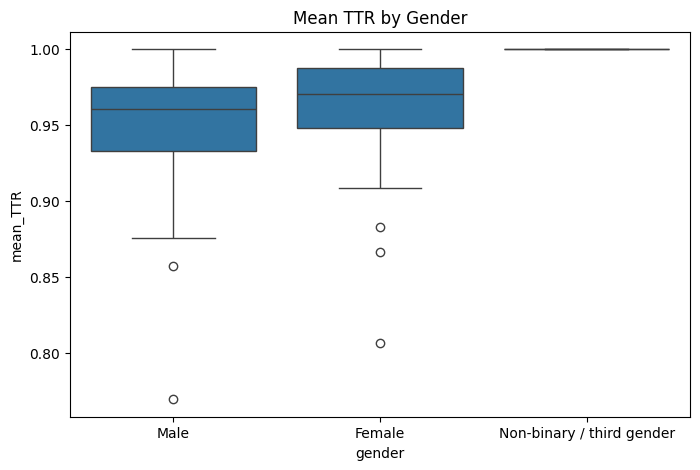

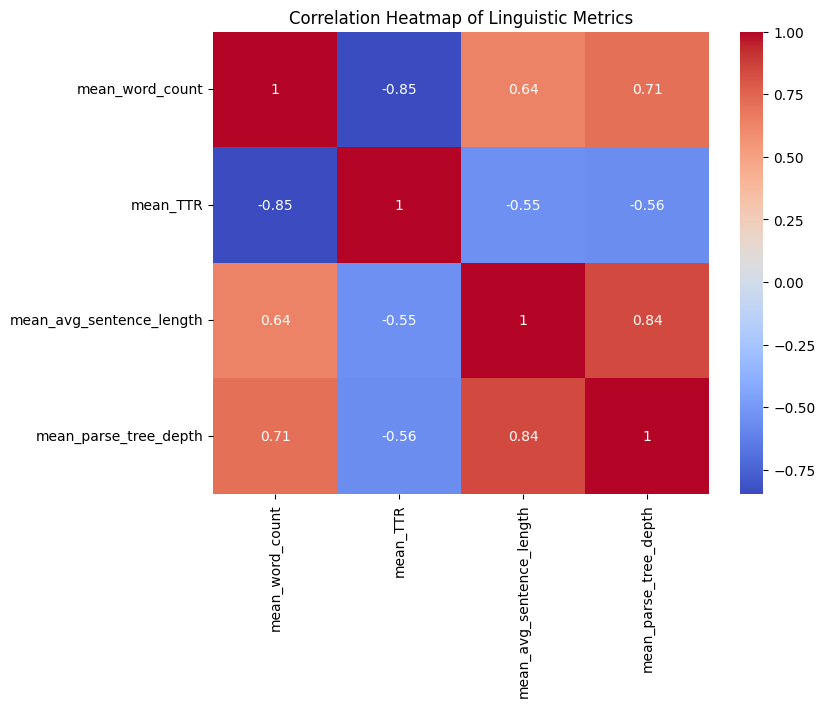

In [24]:
demographics = df[['user_id', 'age', 'gender', 'employment_status', 'education',
                   'marital_status', 'english_proficiency', 'study_locale',
                   'religion', 'ethnicity', 'location']].drop_duplicates()

# Merge the user-level linguistic metrics with the demographic info
user_data = pd.merge(user_level, demographics, on='user_id', how='left')

print("Merged user data (first 5 rows):")
print(user_data.head())


print("\nDescriptive statistics for linguistic metrics:")
print(user_data[['mean_word_count', 'mean_TTR', 'mean_avg_sentence_length', 'mean_parse_tree_depth']].describe())

print("\nGroup means by gender:")
print(user_data.groupby("gender")[['mean_word_count', 'mean_TTR', 'mean_avg_sentence_length', 'mean_parse_tree_depth']].mean())

print("\nGroup means by age:")
print(user_data.groupby("age")[['mean_word_count', 'mean_TTR', 'mean_avg_sentence_length', 'mean_parse_tree_depth']].mean())

print("\nCorrelation matrix for linguistic metrics:")
print(user_data[['mean_word_count', 'mean_TTR', 'mean_avg_sentence_length', 'mean_parse_tree_depth']].corr())


# Example: Boxplot of mean TTR by gender
plt.figure(figsize=(8, 5))
sns.boxplot(x="gender", y="mean_TTR", data=user_data)
plt.title("Mean TTR by Gender")
plt.show()

# Example: Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(user_data[['mean_word_count', 'mean_TTR', 'mean_avg_sentence_length', 'mean_parse_tree_depth']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Linguistic Metrics")
plt.show()


Regression Results for Mean Word Count:
                            OLS Regression Results                            
Dep. Variable:        mean_word_count   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.212
Date:                Sun, 09 Mar 2025   Prob (F-statistic):              0.260
Time:                        00:36:32   Log-Likelihood:                -459.88
No. Observations:                 137   AIC:                             959.8
Df Residuals:                     117   BIC:                             1018.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

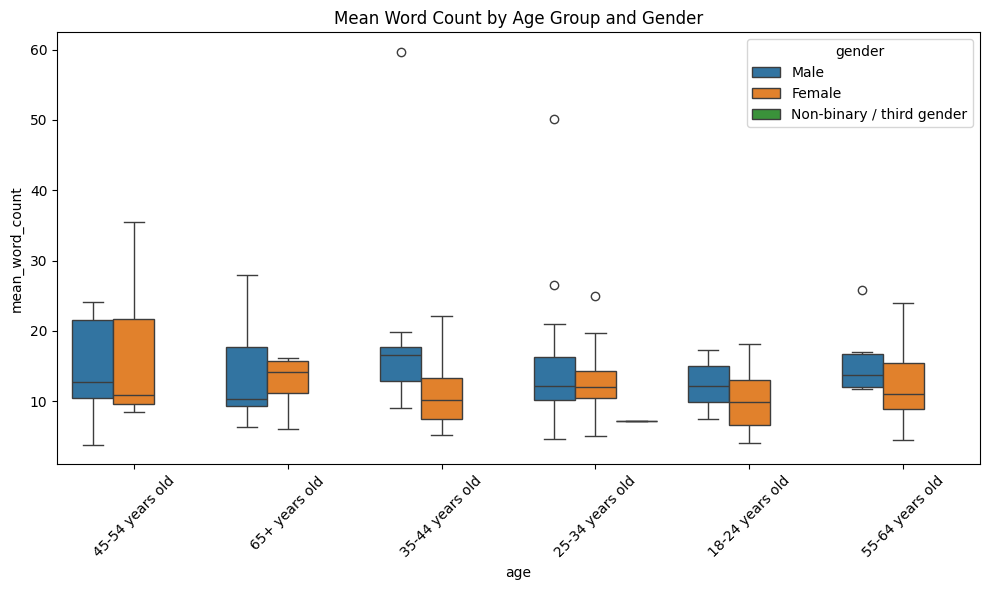

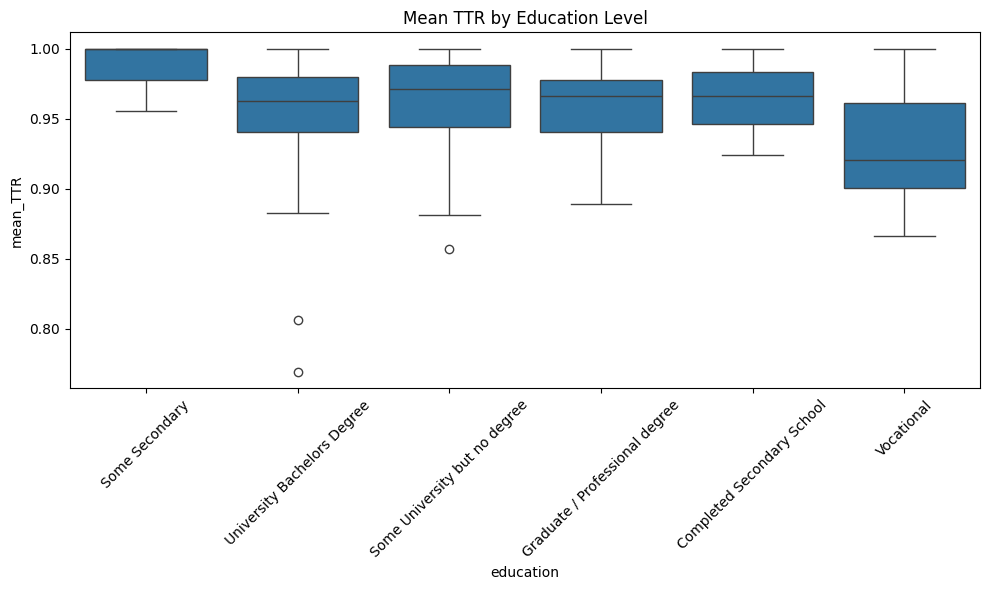

In [25]:
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


model_word = smf.ols("mean_word_count ~ C(age) + C(gender) + C(education) + C(employment_status)", data=user_data).fit()
print("Regression Results for Mean Word Count:")
print(model_word.summary())

model_TTR = smf.ols("mean_TTR ~ C(age) + C(gender) + C(education) + C(employment_status)", data=user_data).fit()
print("\nRegression Results for Mean TTR:")
print(model_TTR.summary())

model_sentence = smf.ols("mean_avg_sentence_length ~ C(age) + C(gender) + C(education) + C(employment_status)", data=user_data).fit()
print("\nRegression Results for Mean Average Sentence Length:")
print(model_sentence.summary())

model_tree = smf.ols("mean_parse_tree_depth ~ C(age) + C(gender) + C(education) + C(employment_status)", data=user_data).fit()
print("\nRegression Results for Mean Parse Tree Depth:")
print(model_tree.summary())


plt.figure(figsize=(10, 6))
sns.boxplot(x="age", y="mean_word_count", hue="gender", data=user_data)
plt.title("Mean Word Count by Age Group and Gender")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Example: Visualizing Mean TTR by Education Level
plt.figure(figsize=(10, 6))
sns.boxplot(x="education", y="mean_TTR", data=user_data)
plt.title("Mean TTR by Education Level")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Regression Results for Mean Word Count with Interaction Terms:
                            OLS Regression Results                            
Dep. Variable:        mean_word_count   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     1.149
Date:                Sun, 09 Mar 2025   Prob (F-statistic):              0.291
Time:                        00:40:06   Log-Likelihood:                -448.48
No. Observations:                 137   AIC:                             971.0
Df Residuals:                     100   BIC:                             1079.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
------

c:\Users\theal\.conda\envs\linegym\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])



Random Forest Regression R^2 on test set for mean_word_count: -0.45427048782814183

Feature Importances for predicting mean_word_count:
age_35-44 years old                   0.091632
ethnicity_Other                       0.083178
location_Australia and New Zealand    0.074927
religion_No Affiliation               0.068895
gender_Male                           0.056468
                                        ...   
gender_Non-binary / third gender      0.000000
study_locale_netherlands              0.000000
study_locale_ireland                  0.000000
study_locale_finland                  0.000000
study_locale_austria                  0.000000
Length: 69, dtype: float64


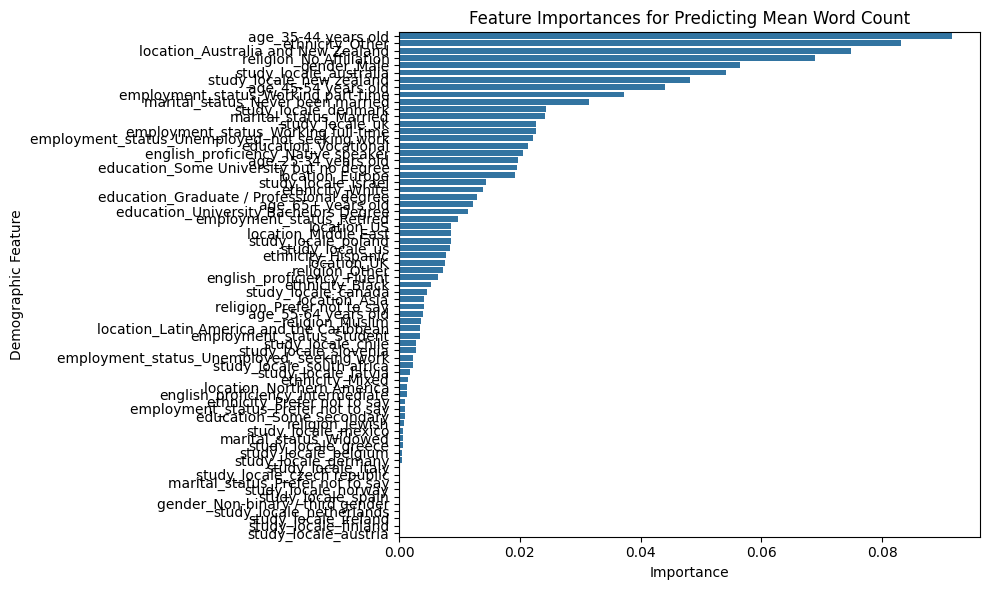

In [27]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np


model_interaction = smf.ols(
    "mean_word_count ~ C(age) * C(education) + C(gender) + C(employment_status)",
    data=user_data
).fit()
print("Regression Results for Mean Word Count with Interaction Terms:")
print(model_interaction.summary())

model_interaction2 = smf.ols(
    "mean_TTR ~ C(gender) * C(marital_status) + C(age) + C(education)",
    data=user_data
).fit()
print("\nRegression Results for Mean TTR with Gender x Marital Status Interaction:")
print(model_interaction2.summary())


demographic_features = ['age', 'gender', 'education', 'employment_status', 
                        'marital_status', 'english_proficiency', 'study_locale', 
                        'religion', 'ethnicity', 'location']

X = pd.get_dummies(user_data[demographic_features], drop_first=True)
y = user_data['mean_word_count']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
r2 = rf.score(X_test, y_test)
print("\nRandom Forest Regression R^2 on test set for mean_word_count:", r2)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importances for predicting mean_word_count:")
print(feature_importances)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Feature Importances for Predicting Mean Word Count")
plt.xlabel("Importance")
plt.ylabel("Demographic Feature")
plt.tight_layout()
plt.show()
